In [13]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib
import sklearn

from dotenv import load_dotenv
load_dotenv()

True

In [14]:
datasets_path = os.getenv("LIBSVM_DIR")
datasets_params = {
    "webspam": {
        "train_path": f"{datasets_path}/webspam/train_data",
        "test_path": f"{datasets_path}/webspam/test_data",
        "val_path": f"{datasets_path}/webspam/val_data",
        "n_features": 16_609_143, 
        },
    "news20":
        {
        "train_path": f"{datasets_path}/news20/news20.binary",
        "n_features": 1_355_191, 
        },
    "a1a": {
        "train_path": f"{datasets_path}/a1a",
        "test_path": f"{datasets_path}/a1a.t",
        "n_features": 123,
    }
}

In [15]:
import svmlight_loader

dataset_name = "a1a"
train_path = datasets_params[dataset_name]["train_path"]
n_features = datasets_params[dataset_name]["n_features"]
print(train_path)
X, y = svmlight_loader.load_svmlight_file(train_path, n_features=n_features)

n, d = X.shape
print("We have %d samples, each has up to %d features"%(n,d))

/l/users/farshed.abdukhakimov/libsvm/a1a
We have 1605 samples, each has up to 123 features


# Task - normalize the data

In [ ]:
import sklearn
from sklearn.preprocessing import normalize
X = normalize(X, norm='l2', axis=1) # normalize such that each row will have \|\cdot\|_2 = 1

In [ ]:
# X.nnz/(d*n)

0.0015487482911152007

# Let's do Logistic Regression

$$
F(w) = \frac1n \sum_{i=1}^n \log(1+e^{-y_i x_i^T w})
$$
$$
\nabla F(w) = 
$$


In [ ]:
import scipy

In [16]:
# define functions that will comptute gradient 

def F(X, y, w):
  """ Compute the function value of Logisitic """
  return np.mean(np.log(1+np.exp(-y*X.dot(w))))

def F_and_grad_and_acc(X, y, w, s):
  """ Compute the function gradient of Logisitic """
#   print(X[s].shape)

  r = -y[s]*X[s].dot(w)
  expr = np.exp(r);
  grad= X[s].T.dot(-expr/(1+expr)*y[s])   
  return np.mean(np.log(1+expr)), grad/X.shape[0]


import numba as nb
import time

def F_and_grad_and_acc_EFF(X, y, w, s):
  """ Compute the function gradient of Logisitic """
#   print(X[s].shape)

  r = -y[s]*X[s].dot(w)
  expr = np.exp(r);
  grad=  -expr/(1+expr)*y[s]   
  return np.mean(np.log(1+expr)), grad/X.shape[0]


# st = time.time()
# for i in range(n//bs):
#     s = S[i*bs:(i+1)*bs]
#     f,g = F_and_grad_and_acc_EFF(X, y, w, s)
# #     gg = X[s].T.dot(g)
#     for l, gi in enumerate(g):
#         w[  X[s[l]].indices  ] -= 1.2 *gi*X[s[l]].data    
# print(time.time()-st)


In [18]:
from numba import njit
@njit
def add_to_w(w, g, s,Xdata, XrowPtr, XcolIdx, eta):
    for i, gi in enumerate(g):
        row = s[i]
        rowStI = XrowPtr[row]
        rowStE = XrowPtr[row+1]
        w[XcolIdx[rowStI:rowStE]] -= eta*gi*Xdata[rowStI:rowStE]
    return 



20.3258638381958


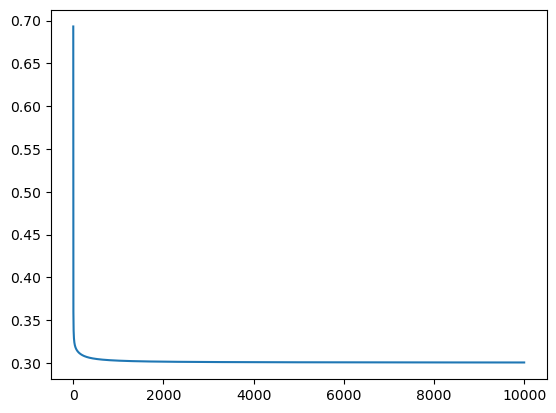

In [28]:
np.random.seed(0)
w = np.zeros(d)
S = list(range(n))
bs = 128
epochs = 10000
eta = 10
st = time.time()
fvals = []
for e in range(epochs):
    fvals.append(F(X,y,w))
    for i in range(n//bs):
        s = S[i*bs:(i+1)*bs]
        f, g = F_and_grad_and_acc_EFF(X, y, w, s)
        add_to_w(w,g,np.array(s), X.data, X.indptr, X.indices,      eta)
print(time.time()-st)             
fvals.append(F(X,y,w))
plt.plot(fvals)
fvalEfficient = fvals

10.301262855529785 0.613009239459799


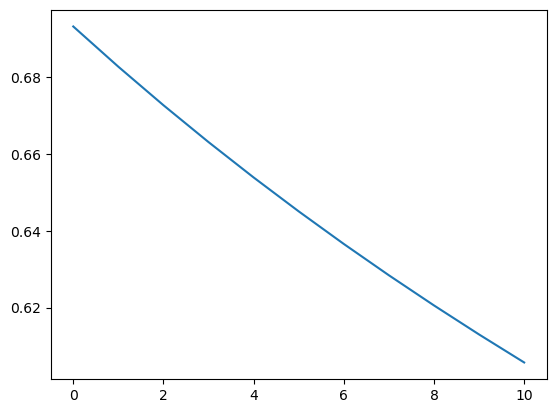

In [ ]:
np.random.seed(0)
w = np.zeros(d)
S = list(range(n))
st = time.time()
fvals = []
for e in range(epochs):
    fvals.append(F(X,y,w))
    for i in range(n//bs):
        s = S[i*bs:(i+1)*bs]
        f, g = F_and_grad_and_acc(X, y, w, s)
        w -= eta*g
print(time.time()-st,fvals[-1])            
fvals.append(F(X,y,w))
plt.plot(fvals)

In [ ]:
1-sum(g==0)/d

0.05309509695994585

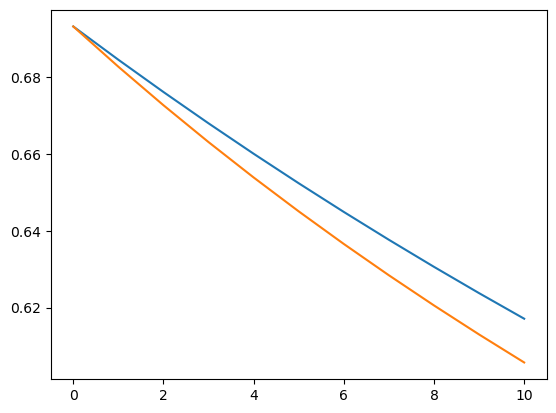

In [ ]:
plt.plot(fvalEfficient)
plt.plot(fvals)

In [ ]:
# define functions that will comptute gradient 
np.random.seed(0)
w = np.random.randn(d)
def F(X, y, w):
  """ Compute the function value of Logisitic """
  return np.mean(np.log(1+np.exp(-y*X.dot(w))))

def grad(X, y, w):
  """ Compute the function gradient of Logisitic """
  r = -y*X.dot(w)
  expr = np.exp(r);
  grad= X.T.dot(-expr/(1+expr)*y)   
  return grad/X.shape[0]


# Task #1 - Proximal Gradient Method
*  let's solve logistic regression problem 
*  let's consider following constrain $X = \{w\ : \ \|w\|_\infty \leq R\}$
*  search online to find a close form solution how to project onto $\ell_\infty$ ball
*  play with various values of $R$ and show how the optimal function value depends on $R$. Should it be incrasing or decreasing function?

## Solution
The projection into $l_\infty$ ball is as follow:
$$
\Pi_{ { \left\| \cdot \right\| }_{\infty} \leq R } \left( x \right)_i = \begin{cases}
    R, & \text{if} & {x}_{i} \geq R \\
    {x}_{i}, & \text{if} & \left | {x}_{i} \right | < R \\
    -R, & \text{if} & {x}_{i} \leq -R
  \end{cases}
  $$
  Closed form projecition can be implemented using Moreau decomposition (later to see in classes), you can try both and see they produce the same projection.\\

$$
x = prox_{f}(x) + prox_{f^*}(x)
$$
where $f^*$ is the conjugate function of $f$ defined as
$$
f^*(y) = \underset{x}{\sup}\;(x^Ty - f(x))
$$
In the case of norms, the conjugate function has a special formulation, which is the indicator function, i.e. if $f(x) = \|x\|_p$, for $p\geq1$, then $f^∗(x)=1_{\|x\|_q\leq1}(x)$, where $1/p+1/q=1$, and the indicator function is:
\begin{equation}
  1_S(x)=\begin{cases}
    0, & \text{if $x \in S$}.\\
    \infty, & \text{if $x \notin S$}.
  \end{cases}
\end{equation}

where $\|x\|_q$ is the dual norm and is defined as 
$$
\|y\|_* = \underset{x}{\sup}x^Ty \text{ ; } \|x\| \leq 1
$$
The dual norm of $L_\infty$ is $L_1$, (drop me email for more about this if you interested). Now we can find the proximal operator of the conjugate function as
$$
\textrm{prox}_{f^*}(x) = \underset{z}{\arg\min} \; \left(1_{\{\|z\|_1 \leq 1\}} + \|z - x\|_2^2 \right)
$$
which is nothing other than the projection into $L_1$ Ball, thus the closed form projection into $L_\infty$ Ball is:
$$
\Pi_{ { \left\| \cdot \right\| }_{\infty} \leq R } \left( x \right)_i = x - prox_{R,\|x\|_1}(x) = x - sign(x)\text{ } max(|x|-R,0)
  $$
The R value denotes the size of the feasible set; in general, if the minimizer is outside the ball, the loss function will be larger; consequently, raising R increases the probability of finding the minimizer and so reduces the loss function. 

  reference: 
  https://web.stanford.edu/~boyd/papers/pdf/prox_algs.pdf

  Dallas Card (https://math.stackexchange.com/users/293445/dallas-card), The Proximal Operator of the $ {L}_{\infty} $ (Infinity Norm), URL (version: 2020-03-20): https://math.stackexchange.com/q/1550756

In [ ]:
# Inf Norm operator
def l_inf(w,R):
  """ L_infty projection"""
  for i in range(w.size):
    if w[i] > R : w[i] = R
    if w[i] < -R : w[i] = -R
  return w
def prox_inf(z, R):
  """ L_infty closed form projection"""
  return z - np.sign(z)* np.maximum(np.abs(z) - R,0)

Text(0.5, 1.0, '$L_\\infty$-norm')

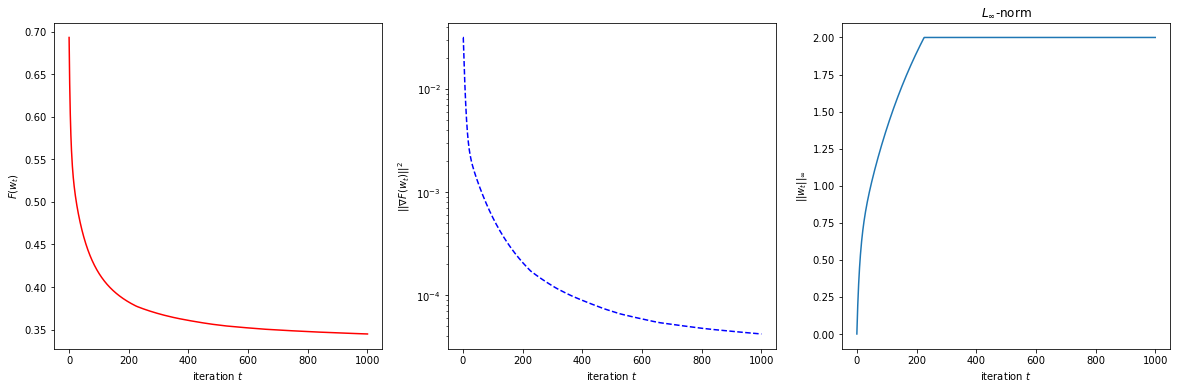

In [ ]:
w = np.zeros(d)

    
gamma=1
R = 2
g = grad(X, y, w)
hist = [[F(X, y, w),np.linalg.norm(g)**2,np.max(np.abs(w))]] # append here function value and square norm of specially chosen subgradient 
          # for initial point and also after each iteration

    
for it in range(1000):
  g = grad(X, y, w)
  # take gradient step
  w = w - gamma * g
  # project onto constraint
  # w = l_inf(w,R)
  w = l_inf(w,R)
  hist.append([F(X, y, w),np.linalg.norm(g)**2,np.max(np.abs(w))])

hist=np.array(hist)  

#plot images
fig,axs = plt.subplots(1,3);fig.set_size_inches(20, 6)
axs[0].plot(hist[:,0],'-r');axs[0].set_ylabel(r"$F(w_t)$");axs[0].set_xlabel(r"iteration $t$") 
axs[1].semilogy(hist[:,1],'--b');axs[1].set_ylabel(r"$||\nabla F(w_t)||^2$");axs[1].set_xlabel(r"iteration $t$")
axs[2].plot(hist[:,2],'-');axs[2].set_ylabel(r"$||w_t||_{\infty}$");axs[2].set_xlabel(r"iteration $t$");axs[2].set_title('$L_\infty$-norm')

# Task #2 - Proximal Algorithm - Group Lasso
*  we already saw in lecture how to achieve sparse solutions (adding $\ell_1$ constraint or penalty)
*  now, we will explore Group Lasso, that can produce block sparsity
*  we will consider function $\Xi(w) = F(w) +\lambda H(w)$, with $F$ being the logistic regression as defined above
*  we will define $H(w) := \| w[0:10]\| + \|w[10:20]\| + \dots + \|w[110:120\|$, where $w[0:10]$ are the first 10 coordinates of vector $w$ and the norm is just classical $\ell_2$ norm, but careful, the norm is NOT squared! 
*  try different values of $\lambda$ and observe that once $\lambda$ achieves some critical value, all coorinates in some particular block will become $0$! You have to derive the proximal operator.



## Solution:
The classical GD step for minimizing F is simply minimzing quadratic approximation of F around w formed by replacing $\nabla^2F(x)$ by $\frac{1}{\gamma}\mathbf{I}$ in Taylor approximation:
$$
w_{t+1} = argmin_w F(w_t)+\nabla F(w_t)^T(w-w_t)+\frac{1}{2\gamma}||w-w_t||^2
$$
Now for f = F + H, where H is non-smooth we do exactly the same for F but add H as it is:
$$
w_{t+1} = \ argmin_w F(w_t)+\nabla F(w_t)^T(w-w_t)+\frac{1}{2\gamma}|| w-w_t||^2 + \lambda H(w)
$$
If we add and substract the following, which is not function of w:
$$
w_{t+1} = \ argmin_w F(w_t)+\nabla F(w_t)^T(w-w_t)+\frac{1}{2\gamma}|| w-w_t||^2 + \|\sqrt{\frac{\gamma}{2}}\nabla F(w_t) \|^2
 - \|\sqrt{\frac{\gamma}{2}}\nabla F(w_t) \|^2
 + \lambda H(w)
$$
we can rewrite it as follow after we dropped terms don't depend on w:
$$
w_{t+1} = argmin_w \frac{1}{2\gamma}||w-(w_t-\gamma\nabla F(w_t) ||^2 + \lambda H(w) \\= prox_{\lambda\gamma,H}(w_t-\gamma\nabla F(w_t))
$$
In other words, the proximal operator takes the GD step and seeks the next point with the smallest feasible distance to the GD step and minimal H(w). 

Group Lasso is defined as:
$H(w) = \sum_{g}^{G} \|w^g\|_2$ where G is number of groups
\\
The proximal operator can be rewritten as:
$$
w_{k+1} = \min_w ( \sum_{g}^{G} \frac{1}{2\gamma} \|w^g- z^g\|^2 + \lambda  \sum_{g}^{G} \|w^g\|)
$$ where $z^g$ is gradient step on group g.
We will consider every group alone since it's seperable and use the property of proximal operator, namely $prox_{f}(x) = (prox_{f_1}(x^1),prox_{f_2}(x^2),...,prox_{f_G}(x^g))$:
$$
w^g_{k+1} = \min_w (\frac{1}{2\gamma} \|w^g- z^g\|^2 + \lambda  \|w^g\|)
$$
Now we can see that every block or group can be projected on $l_2$-Ball using the proximal as follow:
$$
prox_{\lambda\gamma,\|w\|_2}(w_t^g) = (1-\frac{\lambda\gamma}{\|w_t^g\|})_+ w_t^g
$$


  reference: 
  https://web.stanford.edu/~boyd/papers/pdf/prox_algs.pdf


In [ ]:
# Compute group Lasso
def L_21(w,G):
  """ Calculates the group Lasso """
  d = w.size
  elmnts = np.int(np.ceil(d/G))  # elemnts per group
  l_21 = 0
  for g in range(G):
    idx_start = g * elmnts
    idx_end = (g+1) * elmnts
    if idx_end > d : idx_end = d
    l_21 += np.linalg.norm(w[idx_start:idx_end])
  return l_21

# Group lasso Operator
def L_21_prox(w,G,lmd):
  """ Proxmial operator for group lasso"""
  d = w.size
  elmnts = np.int(np.ceil(d/G))  # elemnts per group
  l_21 = 0
  for g in range(G):
    idx_start = g * elmnts
    idx_end = (g+1) * elmnts
    if idx_end > d : idx_end = d
    w[idx_start:idx_end] = w[idx_start:idx_end]*max(0, 1-lmd/np.linalg.norm(w[idx_start:idx_end]));
  return w


<ipython-input-14-366813987b51>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elmnts = np.int(np.ceil(d/G))  # elemnts per group
<ipython-input-14-366813987b51>:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in 

Text(0.5, 0, 'iteration $t$')

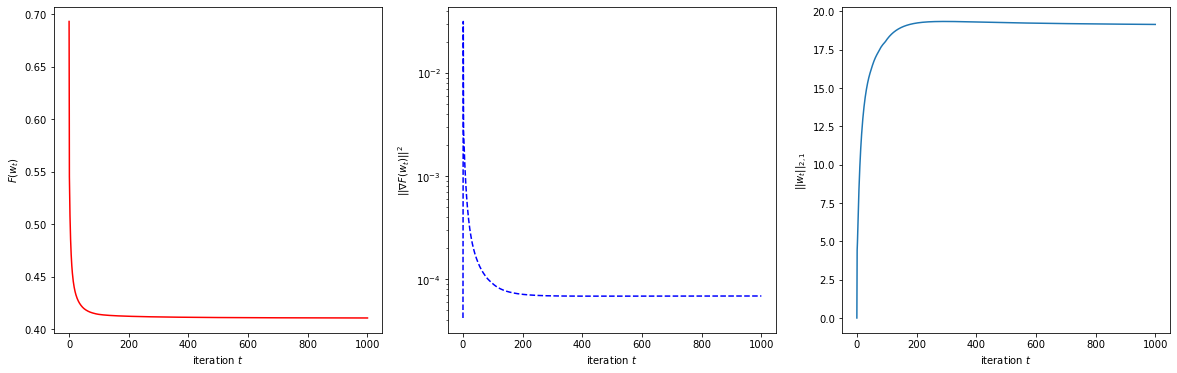

In [ ]:
w = np.zeros(d)

gamma=10
lmd = 5/n
G = 12

hist = [[F(X, y, w)+lmd*L_21(w,G),np.linalg.norm(g)**2,L_21(w,G)]] # append here function value and square norm of specially chosen subgradient 
          # for initial point and also after each iteration
    

for it in range(1000):
  g = grad(X, y, w)
  # take gradient step
  w = w - gamma * g
  # project onto constraint
  # w = l_inf(w,R)
  w = L_21_prox(w,G,lmd*gamma)
  hist.append([F(X, y, w)+lmd*L_21(w,G),np.linalg.norm(g)**2,L_21(w,G)])

hist=np.array(hist)  

#plot images
fig,axs = plt.subplots(1,3);fig.set_size_inches(20, 6)
axs[0].plot(hist[:,0],'-r');axs[0].set_ylabel(r"$F(w_t)$");axs[0].set_xlabel(r"iteration $t$") 
axs[1].semilogy(hist[:,1],'--b');axs[1].set_ylabel(r"$||\nabla F(w_t)||^2$");axs[1].set_xlabel(r"iteration $t$")
axs[2].plot(hist[:,2],'-');axs[2].set_ylabel(r"$||w_t||_{2,1}$");axs[2].set_xlabel(r"iteration $t$")

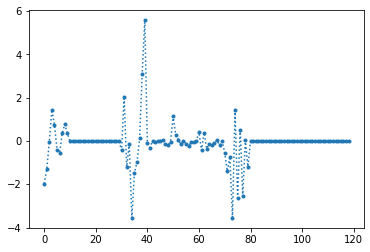

In [ ]:
# How the w looks like with lmd
plt.plot(w,':.',label='$\lambda = 5/n$')

# Task #3 - A small challenge :)

*  last lecture we explore a way to derive an adaptive strategy for adjusting the step-size (or estimate of $L$)
*  could you achieve the same for both algorithms from Task #1 and Task #2?

## Solution
We will implement Nesterov algorithm that automate the step size based on the smoothness upper bound plus the non-smooth function. Check section 3.1 : 
http://www.optimization-online.org/DB_FILE/2007/09/1784.pdf


<ipython-input-14-366813987b51>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elmnts = np.int(np.ceil(d/G))  # elemnts per group
<ipython-input-14-366813987b51>:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in 

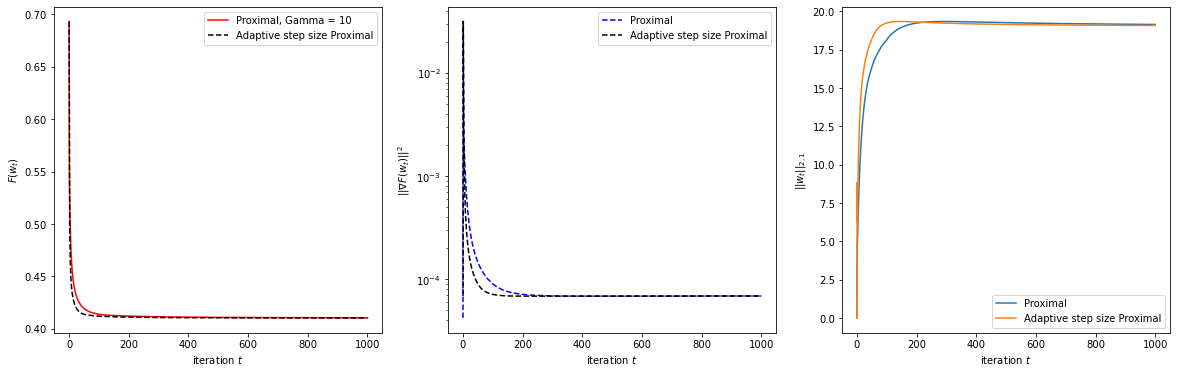

In [ ]:
np.random.seed(0)
w = np.zeros(d)
L = 0.1
lmd = 5/n
G = 12
hist_acc = [[F(X, y, w)+lmd*L_21(w,G),np.linalg.norm(g)**2,L_21(w,G)]]
for k in range(1000):
    g = grad(X, y, w)
    L = 0.1
    while True:
      gamma = 2/L
      w_test = L_21_prox(w - gamma*g,G,lmd*gamma)
      model = F(X,y,w) + g.dot(w_test - w) + L/2 *np.linalg.norm(w_test - w)**2 + lmd * L_21(w_test,G)
      f = F(X,y,w_test) + lmd * L_21(w_test,G)
      Nes_cond = f < model
      if Nes_cond == True : break
      L = L * 1.2
    w = w_test
    hist_acc.append([F(X, y, w)+lmd*L_21(w,G),np.linalg.norm(g)**2,L_21(w,G)])
hist_acc=np.array(hist_acc)  

# plot and compare to Task 2
#plot images
fig,axs = plt.subplots(1,3);fig.set_size_inches(20, 6)
axs[0].plot(hist[:,0],'-r',label= 'Proximal, Gamma = 10');axs[0].set_ylabel(r"$F(w_t)$");axs[0].set_xlabel(r"iteration $t$") 
axs[0].plot(hist_acc[:,0],'--k',label= 'Adaptive step size Proximal')
axs[1].semilogy(hist[:,1],'--b',label= 'Proximal');axs[1].set_ylabel(r"$||\nabla F(w_t)||^2$");axs[1].set_xlabel(r"iteration $t$")
axs[1].semilogy(hist_acc[:,1],'--k',label= 'Adaptive step size Proximal')

axs[2].plot(hist[:,2],'-',label= 'Proximal');axs[2].set_ylabel(r"$||w_t||_{2,1}$");axs[2].set_xlabel(r"iteration $t$")
axs[2].plot(hist_acc[:,2],'-',label= 'Adaptive step size Proximal')

axs[0].legend();axs[1].legend();axs[2].legend()

In [ ]:
a